## Load bag file


In [20]:
import bagpy
from bagpy import bagreader

def load_bag_file(file_path):
    try:
        # Load the bag file
        bag = bagreader(file_path)
        print(f"Bag loaded successfully: {file_path}")
        return bag
    except Exception as e:
        print(f"Failed to load bag file: {e}")
        return None

In [21]:
file_path="./test_bag.bag"
bag = load_bag_file(file_path)

[INFO]  Data folder ./test_bag already exists. Not creating.
Bag loaded successfully: ./test_bag.bag


In [22]:
rgbd = bag.message_by_topic('/hpe3d/rgbd_hpe3d')
op = bag.message_by_topic('/hpe3d/openpose_hpe3d')

In [23]:
import pandas as pd
import numpy as np

rgbd_pd = pd.read_csv(rgbd)
op3d_pd = pd.read_csv(op)
print(op3d_pd.columns)

Index(['Time', 'header.seq', 'header.stamp.secs', 'header.stamp.nsecs',
       'header.frame_id', 'nose.x', 'nose.y', 'nose.z', 'l_eye.x', 'l_eye.y',
       'l_eye.z', 'r_eye.x', 'r_eye.y', 'r_eye.z', 'l_ear.x', 'l_ear.y',
       'l_ear.z', 'r_ear.x', 'r_ear.y', 'r_ear.z', 'neck.x', 'neck.y',
       'neck.z', 'r_shoulder.x', 'r_shoulder.y', 'r_shoulder.z',
       'l_shoulder.x', 'l_shoulder.y', 'l_shoulder.z', 'r_elbow.x',
       'r_elbow.y', 'r_elbow.z', 'l_elbow.x', 'l_elbow.y', 'l_elbow.z',
       'r_wrist.x', 'r_wrist.y', 'r_wrist.z', 'l_wrist.x', 'l_wrist.y',
       'l_wrist.z', 'r_hip.x', 'r_hip.y', 'r_hip.z', 'l_hip.x', 'l_hip.y',
       'l_hip.z', 'r_knee.x', 'r_knee.y', 'r_knee.z', 'l_knee.x', 'l_knee.y',
       'l_knee.z', 'r_ankle.x', 'r_ankle.y', 'r_ankle.z', 'l_ankle.x',
       'l_ankle.y', 'l_ankle.z'],
      dtype='object')


In [24]:
print(rgbd_pd.iloc[0]['nose.x'])

p_n = np.array([rgbd_pd.iloc[0]['nose.x'], rgbd_pd.iloc[0]['nose.y'], rgbd_pd.iloc[0]['nose.z']])

-0.0371715016663074


In [28]:
def parse_points_to_arrays(rgbd_pd, i):
    """
    Converts the data from a DataFrame into NumPy arrays representing points.

    Args:
        rgbd_pd (pd.DataFrame): DataFrame containing point data.

    Returns:
        dict: A dictionary with point names as keys and corresponding NumPy arrays as values.
    """
    # Initialize a dictionary to store the points
    points_dict = {}

    # List of point names to follow the convention (e.g., p_n for nose, p_le for left elbow)
    point_map = {
        'nose': 'p_n',
        'l_eye': 'p_le',
        'r_eye': 'p_re',
        'l_ear': 'p_lear',
        'r_ear': 'p_rear',
        'neck': 'p_neck',
        'r_shoulder': 'p_r_shoulder',
        'l_shoulder': 'p_l_shoulder',
        'r_elbow': 'p_r_elbow',
        'l_elbow': 'p_l_elbow',
        'r_wrist': 'p_r_wrist',
        'l_wrist': 'p_l_wrist',
        'r_hip': 'p_r_hip',
        'l_hip': 'p_l_hip',
        'r_knee': 'p_r_knee',
        'l_knee': 'p_l_knee',
        'r_ankle': 'p_r_ankle',
        'l_ankle': 'p_l_ankle'
    }
    
    # Iterate through the point names and assign values to the corresponding arrays
    for key, new_key in point_map.items():
        # Construct the key names for x, y, and z
        x_key = f'{key}.x'
        y_key = f'{key}.y'
        z_key = f'{key}.z'

        points_dict[new_key] = np.array([
            rgbd_pd.iloc[i][x_key],
            rgbd_pd.iloc[i][y_key],
            rgbd_pd.iloc[i][z_key]
        ])
    
    return points_dict


In [29]:
p_dict = parse_points_to_arrays(rgbd_pd, 100)
o_dict = parse_points_to_arrays(op3d_pd, 100)

In [326]:
def get_matrix(df, joint, side='r'):
    # Get the appropriate wrist column names based on side
    x_col = f'{side}_{joint}.x'
    y_col = f'{side}_{joint}.y'
    z_col = f'{side}_{joint}.z'
    # Extract x, y, z coordinates as NumPy arrays
    x = np.array(df[x_col])
    y = np.array(df[y_col])
    z = np.array(df[z_col])
    
    # Combine into a 3x1 matrix
    return np.matrix([x, y, z]).T

In [327]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_points(points_dict):
    """
    Plots the 3D points stored in the points_dict.

    Args:
        points_dict (dict): A dictionary with keys as point names and values as NumPy arrays [x, y, z].
    """
    # Extract x, y, z coordinates from the dictionary
    x_vals = []
    y_vals = []
    z_vals = []
    labels = []

    for key, coords in points_dict.items():
        x_vals.append(coords[0])
        y_vals.append(coords[1])
        z_vals.append(coords[2])
        labels.append(key)

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot
    ax.scatter(x_vals, y_vals, z_vals, c='r', marker='o')

    # Annotate the points with labels
    for i, label in enumerate(labels):
        ax.text(x_vals[i], y_vals[i], z_vals[i], label, size=10)

    # Set labels for the axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Show the plot
    plt.show()

def plot_subplots(s, e, w, side): 
    # Create a figure and a 1x3 subplot
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    if side == 'right': 
        colors = ['salmon', 'tomato', 'coral']
        labels = ['rs', 're' , 'rw']
    if side == 'left': 
        colors = ['teal', 'aqua', 'skyblue']
        labels = ['ls', 'le', 'lw']
    
    # Plot XY axis
    axs[0].scatter(getXcomp(s), getYcomp(s), c=colors[0], marker='^')
    axs[0].scatter(getXcomp(e), getYcomp(e), c=colors[1], marker='o')
    axs[0].scatter(getXcomp(w), getYcomp(w), c=colors[2], marker='v')
    axs[0].set_title('XY Axis')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')
    axs[0].axis('equal')
    axs[0].grid()
    
    # Plot YZ axis
    axs[1].scatter(getYcomp(s), getZcomp(s), c=colors[0])
    axs[1].scatter(getYcomp(e), getZcomp(e), c=colors[1])
    axs[1].scatter(getYcomp(w), getZcomp(w), c=colors[2])
    axs[1].set_title('YZ Axis')
    axs[1].set_xlabel('Y')
    axs[1].set_ylabel('Z')
    axs[1].axis('equal')
    axs[1].grid()
    
    # Plot XZ axis
    axs[2].scatter(getXcomp(s), getZcomp(s), c=colors[0])
    axs[2].scatter(getXcomp(e), getZcomp(e), c=colors[1])
    axs[2].scatter(getXcomp(w), getZcomp(w), c=colors[2])
    axs[2].set_title('XZ Axis')
    axs[2].set_xlabel('X')
    axs[2].set_ylabel('Z')
    axs[2].axis('equal')
    axs[2].grid()
    
    # Adjust the layout
    plt.tight_layout()
    plt.show()


## Kinematics equations

In [328]:
def getRx(phi):
    R = np.matrix([[1, 0, 0],
                   [0, np.cos(phi), -np.sin(phi)], 
                   [0, np.sin(phi), np.cos(phi)]])
    return(R)

def getRy(phi): 
    R = np.matrix([[np.cos(phi), 0, np.sin(phi)], 
                   [0, 1, 0], 
                   [-np.sin(phi), 0, np.cos(phi)]])
    return(R)

def getRz(phi): 
    R = np.matrix([[np.cos(phi), -np.sin(phi), 0], 
                   [np.sin(phi), np.cos(phi), 0], 
                   [0, 0, 1]])
    return(R)

def getT(R, t): 
    if t.shape != (3, 1): 
        t = t.reshape(3,1)
    T_ = np.hstack((R, t))
    T = np.vstack((T_, np.array([0, 0, 0, 1])))
    return(np.round(T, 5))

def getTinv(R, t):

    if t.shape != (3, 1): 
        t = t.reshape(3, 1)
        
    T_ = np.hstack((R.T, -np.matmul(R.T, t)))
    Tinv = np.vstack((T_, np.array([0, 0, 0, 1])))
    
    return (np.round(Tinv, 5))

def getHomoVect(vect): 
    return np.array([vect[0], vect[1], vect[2] , 1])

def getHomoMatrix(M):
    # Hstacking
    # Assumption is that dimension is N samples x 3
    ones = np.ones(M.shape[0]).T.reshape(M.shape[0], 1)
    hM = np.hstack((M, ones))
    return hM

def getXcomp(S): 
    return(np.array(S[:, 0]))
def getYcomp(S): 
    return(np.array(S[:, 1]))
def getZcomp(S): 
    return(np.array(S[:, 2]))

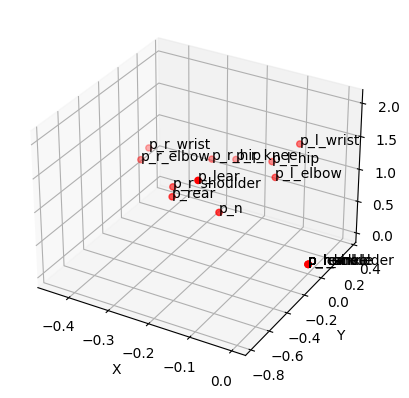

In [39]:
# Example: Plotting the points from the points_dict
plot_3d_points(p_dict)

In [40]:
# RW
r_w_x = np.array(rgbd_pd['r_wrist.x'])
r_w_y = np.array(rgbd_pd['r_wrist.y'])
r_w_z = np.array(rgbd_pd['r_wrist.z'])
RW = np.matrix([r_w_x, r_w_y, r_w_z]).T

# LW
l_w_x = np.array(rgbd_pd['l_wrist.x'])
l_w_y = np.array(rgbd_pd['l_wrist.y'])
l_w_z = np.array(rgbd_pd['l_wrist.z'])

In [41]:
RW = get_matrix(rgbd_pd, joint="wrist", side="r")
LW = get_matrix(rgbd_pd, joint="wrist", side="l")
RE = get_matrix(rgbd_pd, joint="elbow", side="r")
LE = get_matrix(rgbd_pd, joint="elbow", side="l")
RS = get_matrix(rgbd_pd, joint="shoulder", side="r")
LS = get_matrix(rgbd_pd, joint="shoulder", side="l")

Text(0.5, 0, 'Z')

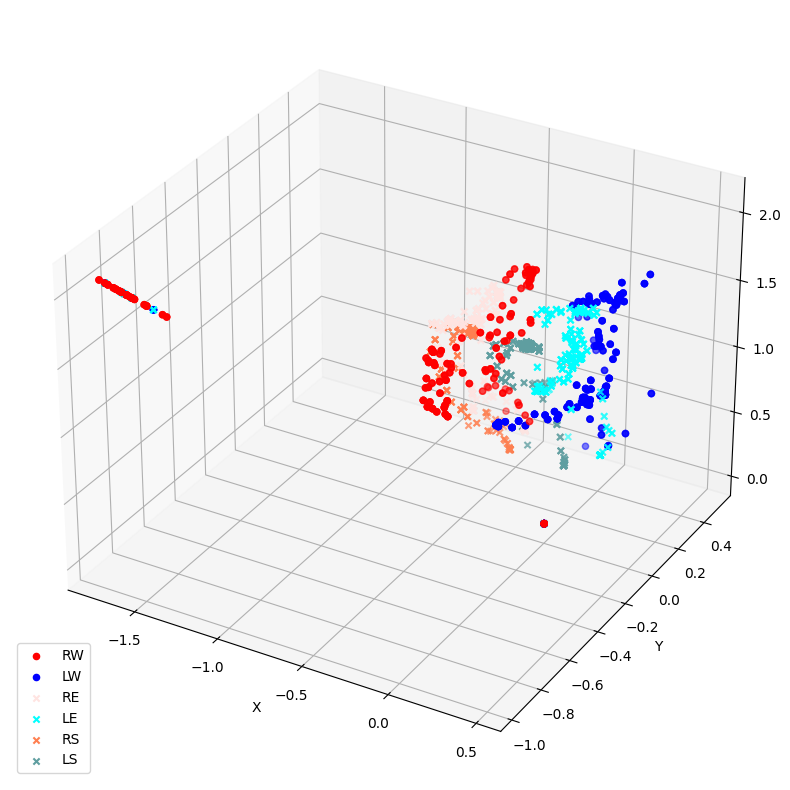

In [42]:
 # Create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot [wrist, elbow, shoulder]
ax.scatter(RW[:, 0], RW[:, 1], RW[:, 2], c='r', marker='o', label='RW')
ax.scatter(LW[:, 0], LW[:, 1], LW[:, 2], c='b', marker='o', label='LW')
ax.scatter(RE[:, 0], RE[:, 1], RE[:, 2], c='mistyrose', marker='x', label='RE')
ax.scatter(LE[:, 0], LE[:, 1], LE[:, 2], c='cyan', marker='x', label='LE')
ax.scatter(RS[:, 0], RS[:, 1], RS[:, 2], c='coral', marker='x', label='RS')
ax.scatter(LS[:, 0], LS[:, 1], LS[:, 2], c='cadetblue', marker='x', label='LS')
ax.legend(loc='lower left')

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Stationary bag

In [211]:
file_path="./no_rot_stationary.bag"
bag = load_bag_file(file_path)

rgbd = bag.message_by_topic('/hpe3d/rgbd_hpe3d')
op = bag.message_by_topic('/hpe3d/openpose_hpe3d')

rgbd_pd = pd.read_csv(rgbd)
op3d_pd = pd.read_csv(op)

[INFO]  Data folder ./no_rot_stationary already exists. Not creating.
Bag loaded successfully: ./no_rot_stationary.bag


In [212]:
RW = get_matrix(rgbd_pd, joint="wrist", side="r")
LW = get_matrix(rgbd_pd, joint="wrist", side="l")
RE = get_matrix(rgbd_pd, joint="elbow", side="r")
LE = get_matrix(rgbd_pd, joint="elbow", side="l")
RS = get_matrix(rgbd_pd, joint="shoulder", side="r")
LS = get_matrix(rgbd_pd, joint="shoulder", side="l")


Text(0.5, 0, 'Z')

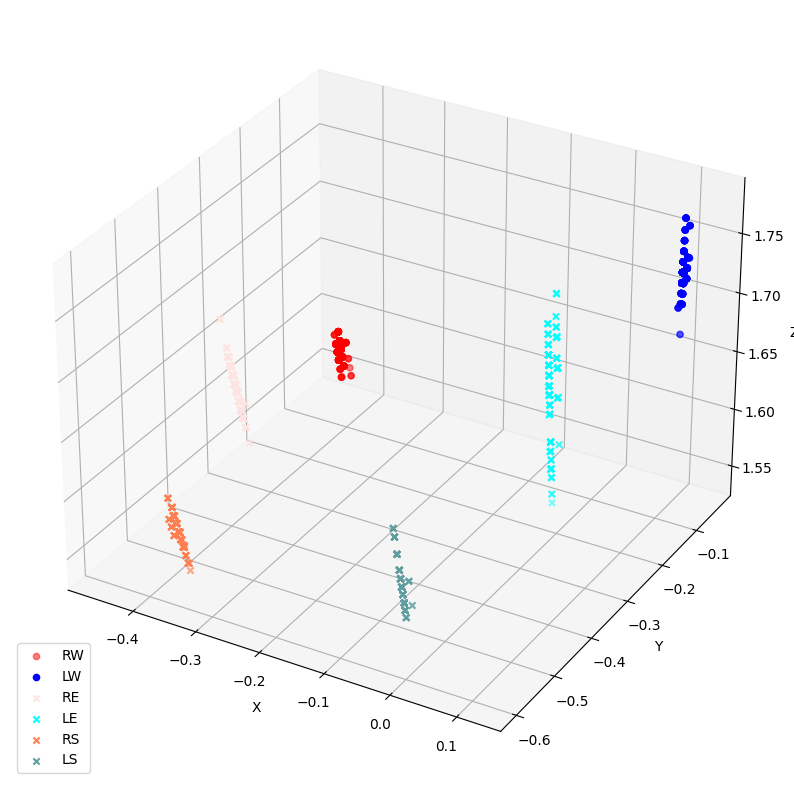

In [214]:
 # Create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot [wrist, elbow, shoulder]
n = 250
ax.scatter(RW[:n, 0], RW[:n, 1], RW[:n, 2], c='r', marker='o', label='RW', alpha=0.5)
ax.scatter(LW[:n, 0], LW[:n, 1], LW[:n, 2], c='b', marker='o', label='LW')
ax.scatter(RE[:n, 0], RE[:n, 1], RE[:n, 2], c='mistyrose', marker='x', label='RE')
ax.scatter(LE[:n, 0], LE[:n, 1], LE[:n, 2], c='cyan', marker='x', label='LE')
ax.scatter(RS[:n, 0], RS[:n, 1], RS[:n, 2], c='coral', marker='x', label='RS')
ax.scatter(LS[:n, 0], LS[:n, 1], LS[:n, 2], c='cadetblue', marker='x', label='LS')

ax.legend(loc='lower left')

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [156]:
rw_mean = np.mean(RW, axis=0)
lw_mean = np.mean(LW, axis=0)
re_mean = np.mean(RE, axis=0)
le_mean = np.mean(LE, axis=0)
rs_mean = np.mean(RS, axis=0)
ls_mean = np.mean(LS, axis=0)

## Convert to the world coordinate frame

In [157]:
N = np.array([rgbd_pd['neck.x'], rgbd_pd['neck.y'], rgbd_pd['neck.z']])
N_mean = np.mean(N, axis=1)
t_init = N_mean
R = np.matmul(getRx(np.pi/2), getRy(np.pi/2))
T_inv = getTinv(R, t_init)

In [174]:
RS_ = getHomoMatrix(RS)
RE_ = getHomoMatrix(RE)
RW_ = getHomoMatrix(RW)

bRS_ = np.matmul(T_inv, RS_.T).T
bRE_ = np.matmul(T_inv, RE_.T).T
bRW_ = np.matmul(T_inv, RW_.T).T

Text(0.5, 0, 'Z')

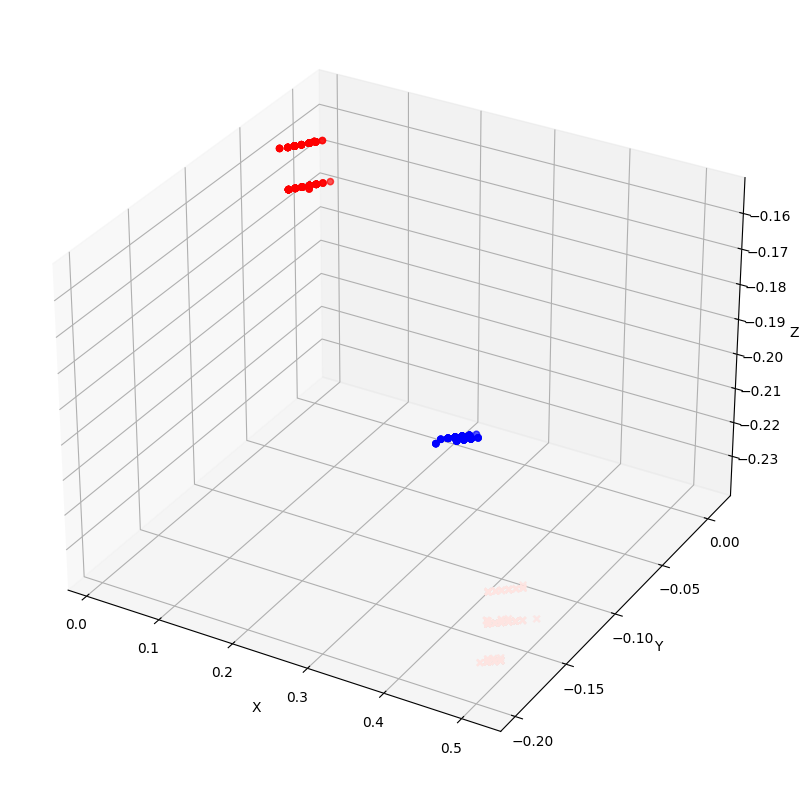

In [176]:
 # Create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot [wrist, elbow, shoulder]
n = 250
ax.scatter(bRS_[:n, 0], bRS_[:n, 1], bRS_[:n, 2], c='r', marker='o', label='RS')
ax.scatter(bRE_[:n, 0], bRE_[:n, 1], bRE_[:n, 2], c='b', marker='o', label='RE')
ax.scatter(bRW_[:n, 0], bRW_[:n, 1], bRW_[:n, 2], c='mistyrose', marker='x', label='RW')

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

## No rot stationary bag

In [337]:
file_path="./no_rot_stationary.bag"
bag = load_bag_file(file_path)

rgbd = bag.message_by_topic('/hpe3d/rgbd_hpe3d')
op = bag.message_by_topic('/hpe3d/openpose_hpe3d')

rgbd_pd = pd.read_csv(rgbd)
op3d_pd = pd.read_csv(op)

def get_pandas(file_path): 
    bag = load_bag_file(file_path)

    rgbd = bag.message_by_topic('/hpe3d/rgbd_hpe3d')
    op = bag.message_by_topic('/hpe3d/openpose_hpe3d')

    rgbd_pd = pd.read_csv(rgbd)
    op3d_pd = pd.read_csv(op)
    return rgbd_pd, op3d_pd
    

[INFO]  Data folder ./no_rot_stationary already exists. Not creating.
Bag loaded successfully: ./no_rot_stationary.bag


In [353]:
RW = get_matrix(rgbd_pd, joint="wrist", side="r")
LW = get_matrix(rgbd_pd, joint="wrist", side="l")
RE = get_matrix(rgbd_pd, joint="elbow", side="r")
LE = get_matrix(rgbd_pd, joint="elbow", side="l")
RS = get_matrix(rgbd_pd, joint="shoulder", side="r")
LS = get_matrix(rgbd_pd, joint="shoulder", side="l")

def get_matrices(pandas): 
    N = np.array([pandas['neck.x'], pandas['neck.y'], pandas['neck.z']])
    RW = get_matrix(pandas, joint="wrist", side="r")
    LW = get_matrix(pandas, joint="wrist", side="l")
    RE = get_matrix(pandas, joint="elbow", side="r")
    LE = get_matrix(pandas, joint="elbow", side="l")
    RS = get_matrix(pandas, joint="shoulder", side="r")
    LS = get_matrix(pandas, joint="shoulder", side="l") 

    return N, RS, RE, RW, LS, RE, LW

In [340]:
N = np.array([rgbd_pd['neck.x'], rgbd_pd['neck.y'], rgbd_pd['neck.z']])
N_mean = np.mean(N, axis=1)
t_init = N_mean
R = np.matmul(getRy(-np.pi/2), getRx(np.pi/2))
# Moving to the body frame 
T_inv = getTinv(R, t_init)
test_N = np.round(np.matmul(T_inv, getHomoVect(N_mean)), 5)
# Test conversion

def getbTc(N): 
    N_mean = np.mean(N, axis=1)
    t_init = N_mean
    R = np.matmul(getRy(-np.pi/2), getRx(np.pi/2))
    T_inv = getTinv(R, t_init)
    return T_inv

In [341]:
# Right side
RS_ = getHomoMatrix(RS)
RE_ = getHomoMatrix(RE)
RW_ = getHomoMatrix(RW)

bRS_ = np.matmul(T_inv, RS_.T).T
bRE_ = np.matmul(T_inv, RE_.T).T
bRW_ = np.matmul(T_inv, RW_.T).T

# Left side
LS_ = getHomoMatrix(LS)
LE_ = getHomoMatrix(LE)
LW_ = getHomoMatrix(LW)

bLS_ = np.matmul(T_inv, LS_.T).T
bLE_ = np.matmul(T_inv, LE_.T).T
bLW_ = np.matmul(T_inv, LW_.T).T

def convertToBodyFrame(RS, RW, RE, LS, LW, LE, T_inv):
    RS_ = getHomoMatrix(RS)
    RE_ = getHomoMatrix(RE)
    RW_ = getHomoMatrix(RW)

    bRS_ = np.matmul(T_inv, RS_.T).T
    bRE_ = np.matmul(T_inv, RE_.T).T
    bRW_ = np.matmul(T_inv, RW_.T).T

    # Left side
    LS_ = getHomoMatrix(LS)
    LE_ = getHomoMatrix(LE)
    LW_ = getHomoMatrix(LW)

    bLS_ = np.matmul(T_inv, LS_.T).T
    bLE_ = np.matmul(T_inv, LE_.T).T
    bLW_ = np.matmul(T_inv, LW_.T).T

    return bRS_, bRE_, bRW_, bLS_, bLE_, bLW_
    
    

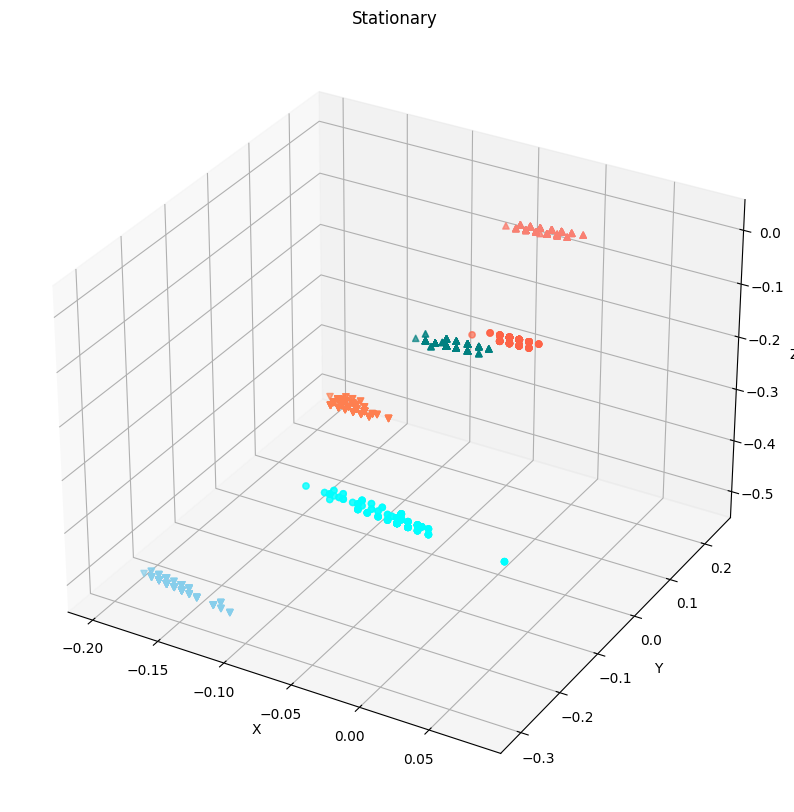

In [364]:

def plot_3d_sew(bRS_, bRE_, bRW_, bLS_, bLE_, bLW_, title): 
    # Create a 3D plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.set_title(title)
    # Scatter plot [wrist, elbow, shoulder]
    n = 250
    # Right side
    ax.scatter(bRS_[:n, 0], bRS_[:n, 1], bRS_[:n, 2], c='salmon', marker='^', label='RS')
    ax.scatter(bRE_[:n, 0], bRE_[:n, 1], bRE_[:n, 2], c='tomato', marker='o', label='RE')
    ax.scatter(bRW_[:n, 0], bRW_[:n, 1], bRW_[:n, 2], c='coral', marker='v', label='RW')

    # Left side
    ax.scatter(bLS_[:n, 0], bLS_[:n, 1], bLS_[:n, 2], c='teal', marker='^', label='RS')
    ax.scatter(bLE_[:n, 0], bLE_[:n, 1], bLE_[:n, 2], c='aqua', marker='o', label='RE')
    ax.scatter(bLW_[:n, 0], bLW_[:n, 1], bLW_[:n, 2], c='skyblue', marker='v', label='RW')

    # Set labels for the axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

plot_3d_sew(bRS_, bRE_, bRW_, bLS_, bLE_, bLW_, title='Stationary') 

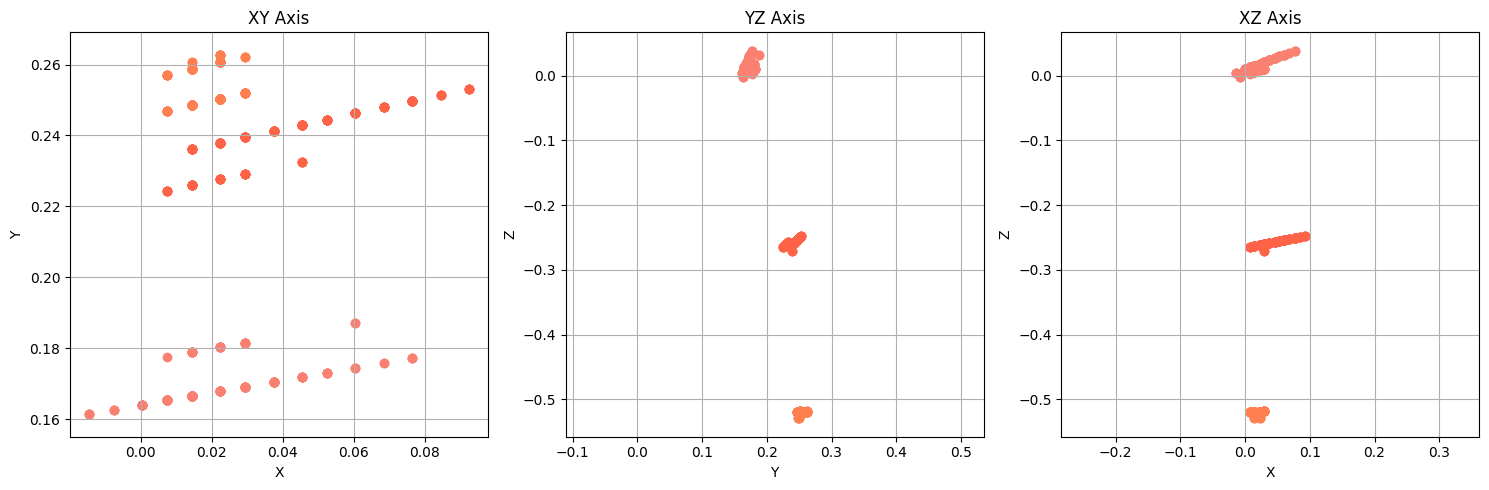

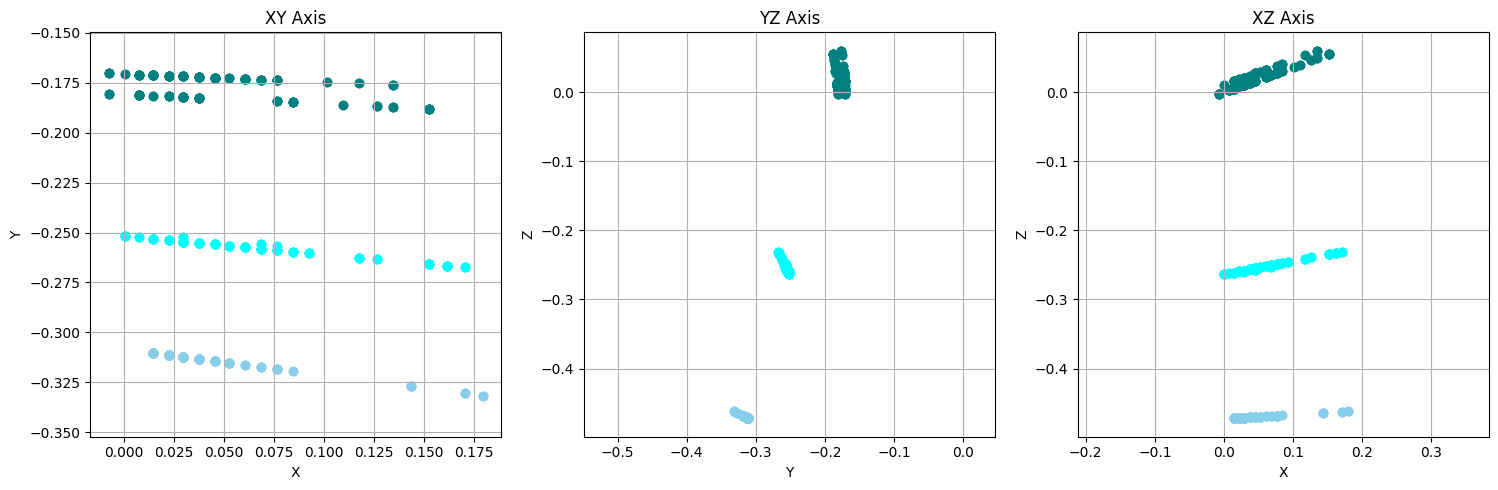

In [349]:
import matplotlib.pyplot as plt
import numpy as np

plot_subplots(bRS_, bRE_, bRW_, 'right')
plot_subplots(bLS_, bLE_, bLW_, 'left')

In [347]:
def getMean(A): 
    return np.mean(A, axis=0)
def getVariance(A): 
    return np.var(A, axis=0)

In [348]:
# Right
bRS_mean = getMean(bRS_)
bRE_mean = getMean(bRE_)
bRW_mean = getMean(bRW_)
bRS_var = getVariance(bRS_)
bRE_var = getVariance(bRE_)
bRW_var = getVariance(bRW_)

print(f"Right shoulder mean: {bRS_mean}")
print(f"Right elbow mean: {bRE_mean}")
print(f"Right wrist mean: {bRW_mean}")

print(f"Right shoulder var: {bRS_var}")
print(f"Right elbow var: {bRE_var}")
print(f"Right wrist var: {bRW_var}")

# Left
bLS_mean = getMean(bLS_)
bLE_mean = getMean(bLE_)
bLW_mean = getMean(bLW_)
bLS_var = getVariance(bLS_)
bLE_var = getVariance(bLE_)
bLW_var = getVariance(bLW_)

print(f"Left shoulder mean: {bLS_mean}")
print(f"Left elbow mean: {bLE_mean}")
print(f"Left wrist mean: {bLW_mean}")

print(f"Left shoulder var: {bLS_var}")
print(f"Left elbow var: {bLE_var}")
print(f"Left wrist var: {bLW_var}")

Right shoulder mean: [[0.02112495 0.16921349 0.01650794 1.        ]]
Right elbow mean: [[ 0.04235352  0.24065207 -0.25786388  1.        ]]
Right wrist mean: [[ 0.0186229   0.25251757 -0.51932741  1.        ]]
Right shoulder var: [[2.50947508e-04 2.51919026e-05 5.04130373e-05 0.00000000e+00]]
Right elbow var: [[4.78429084e-04 5.21797851e-05 1.98708984e-05 0.00000000e+00]]
Right wrist var: [[3.01226183e-05 2.25941005e-05 2.13162074e-06 0.00000000e+00]]
Left shoulder mean: [[ 0.04378618 -0.17605     0.01942635  1.        ]]
Left elbow mean: [[ 0.05996578 -0.25725858 -0.25233779  1.        ]]
Left wrist mean: [[ 0.03734945 -0.31340333 -0.4707242   1.        ]]
Left shoulder var: [[1.27369788e-03 2.94749244e-05 1.95373256e-04 0.00000000e+00]]
Left elbow var: [[1.57724570e-03 1.35824214e-05 6.07424881e-05 0.00000000e+00]]
Left wrist var: [[8.89616009e-04 1.46910150e-05 3.32681798e-06 0.00000000e+00]]


[INFO]  Data folder ./stationary already exists. Not creating.
Bag loaded successfully: ./stationary.bag


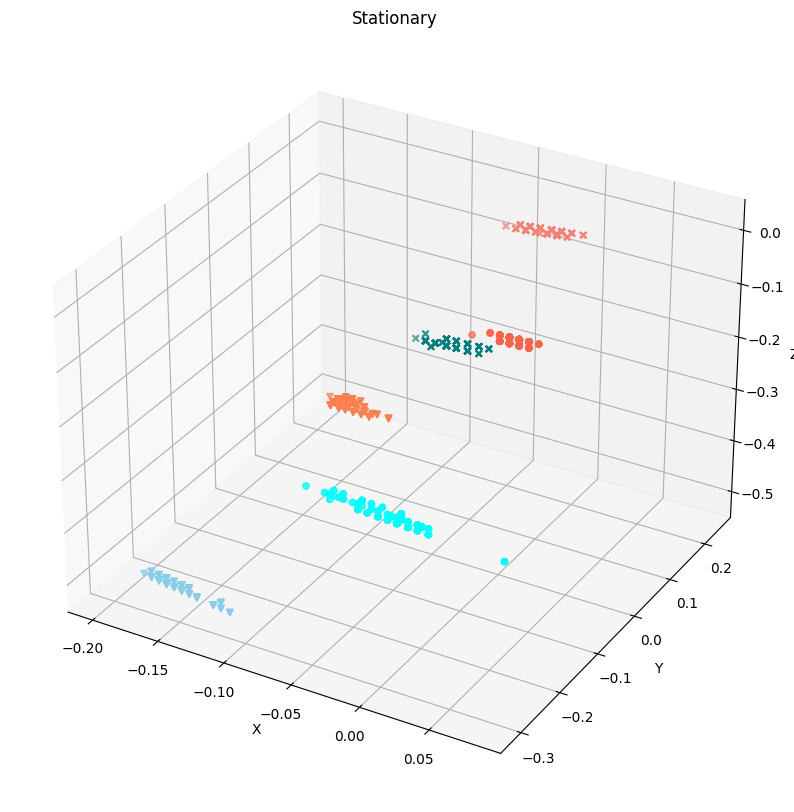

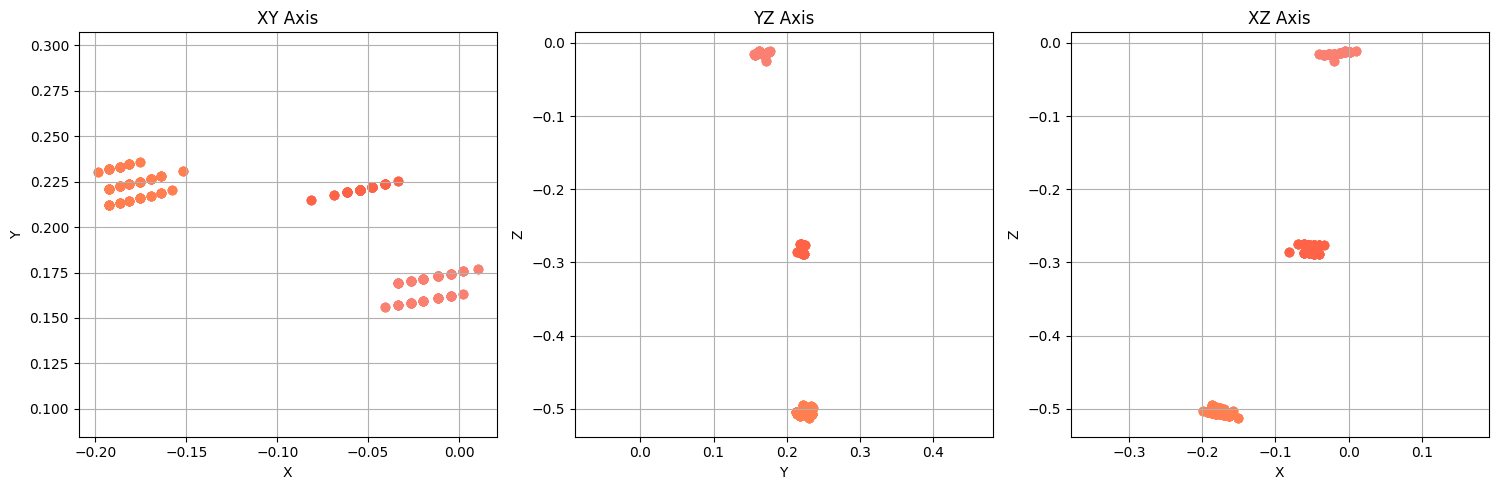

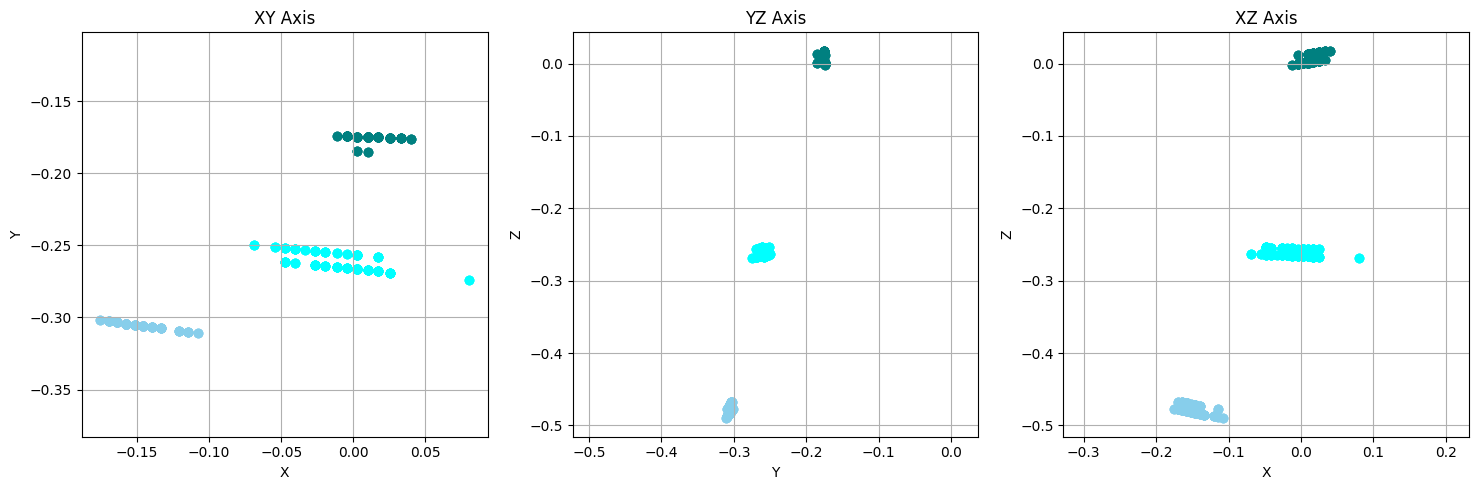

In [363]:
rgbd_pd, o3d_pd = get_pandas('./stationary.bag')
N, RS, RE, RW, LS, RE, LW = get_matrices(rgbd_pd)
T_inv = getbTc(N)
bRS_, bRE_, bRW_, bLS_, bLE_, bLW_ = convertToBodyFrame(RS, RW, RE, LS, LW, LE, T_inv)
plot_3d_sew(bRS_, bRE_, bRW_, bLS_, bLE_, bLW_, title='Stationary') 
plot_subplots(bRS_, bRE_, bRW_, 'right')
plot_subplots(bLS_, bLE_, bLW_, 'left')

[INFO]  Data folder ./slow_movement_elbow already exists. Not creating.
Bag loaded successfully: ./slow_movement_elbow.bag


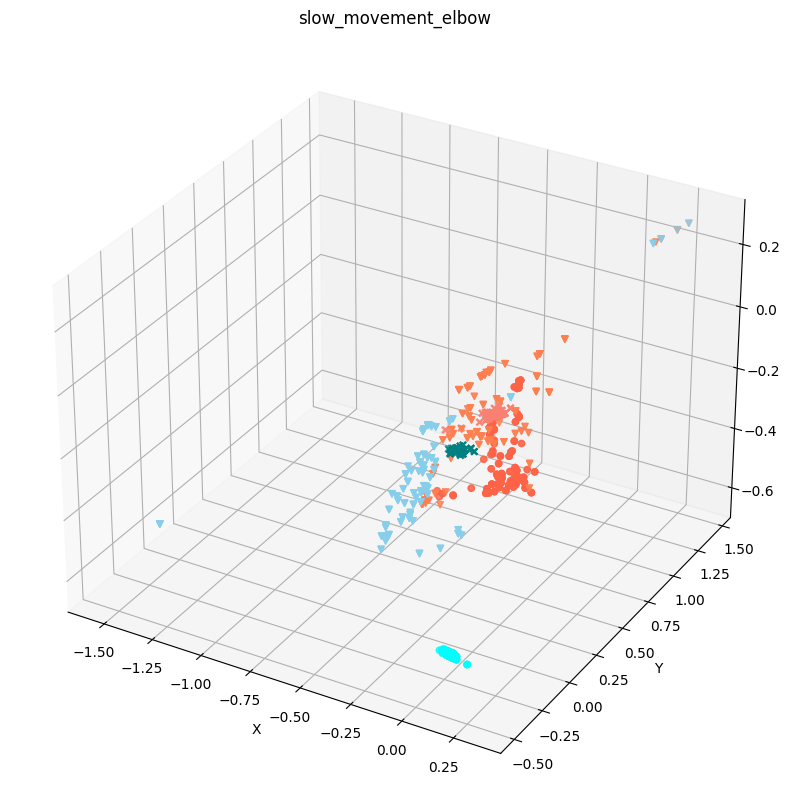

In [359]:
rgbd_pd, o3d_pd = get_pandas('./slow_movement_elbow.bag')
N, RS, RE, RW, LS, RE, LW = get_matrices(rgbd_pd)
T_inv = getbTc(N)
bRS_, bRE_, bRW_, bLS_, bLE_, bLW_ = convertToBodyFrame(RS, RW, RE, LS, LW, LE, T_inv)
plot_3d_sew(bRS_, bRE_, bRW_, bLS_, bLE_, bLW_, title='slow_movement_elbow')

[INFO]  Data folder ./slow_movement_wrist already exists. Not creating.
Bag loaded successfully: ./slow_movement_wrist.bag


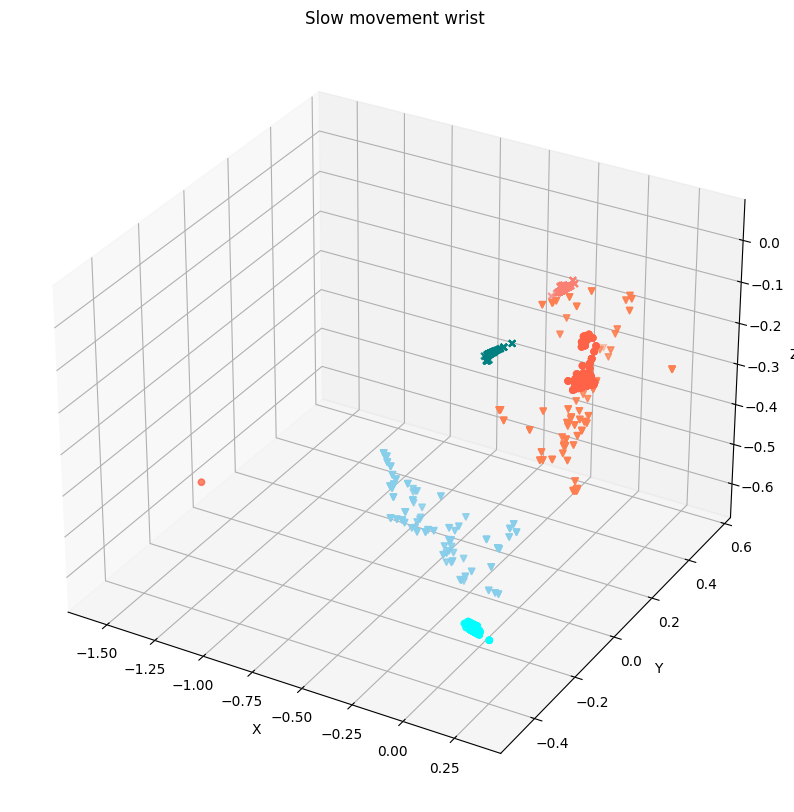

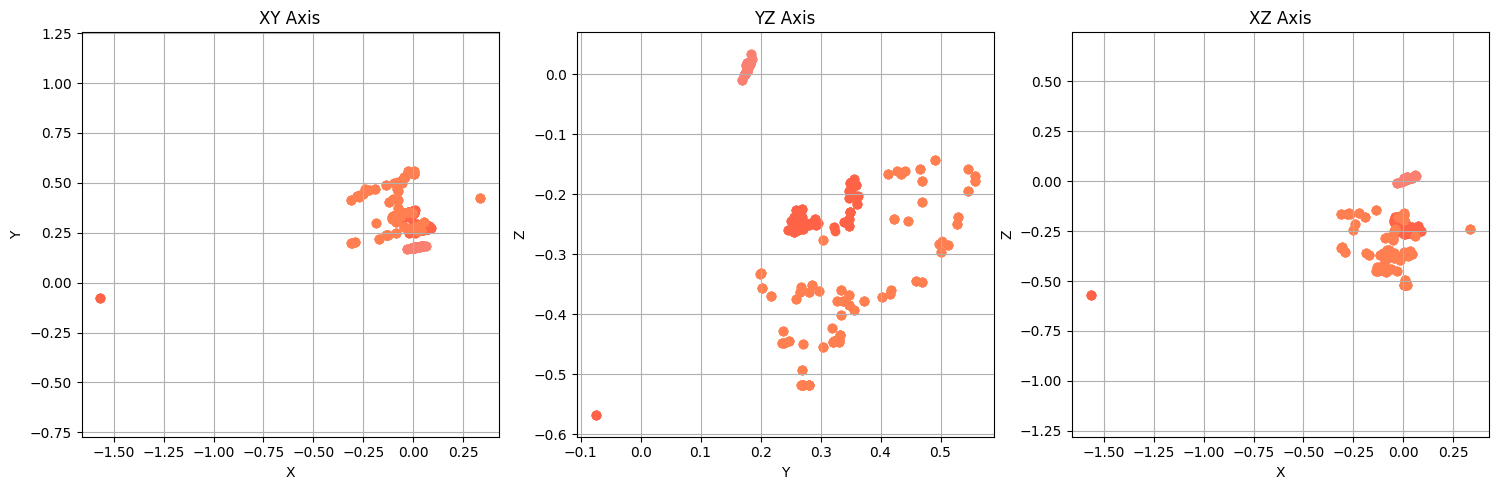

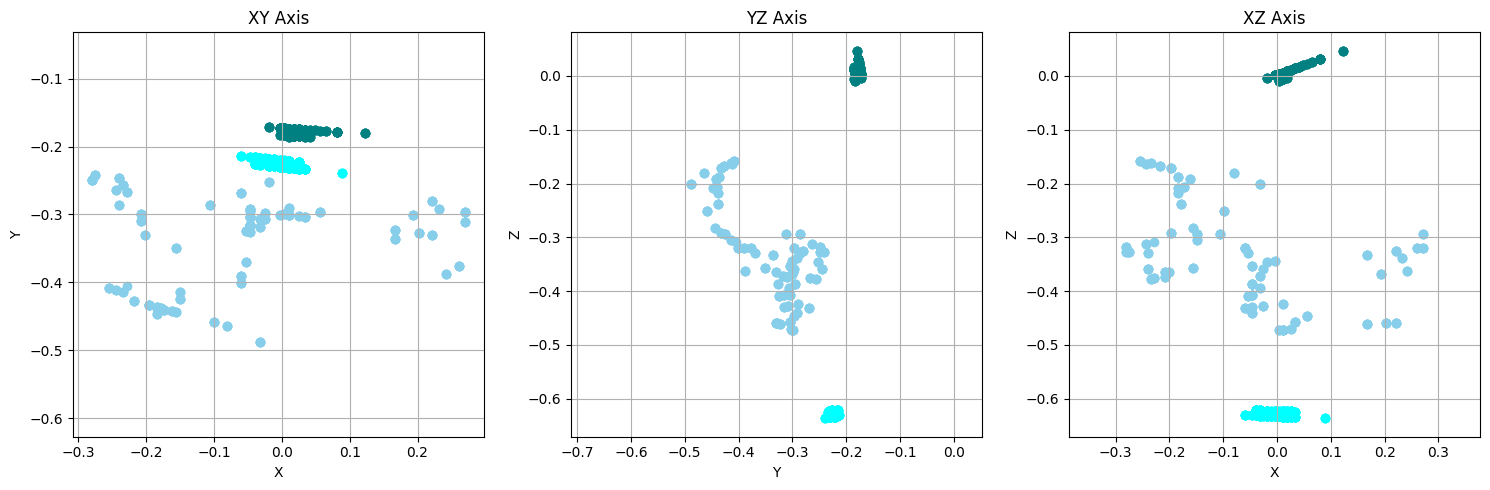

In [361]:
rgbd_pd, o3d_pd = get_pandas('./slow_movement_wrist.bag')
N, RS, RE, RW, LS, RE, LW = get_matrices(rgbd_pd)
T_inv = getbTc(N)
bRS_, bRE_, bRW_, bLS_, bLE_, bLW_ = convertToBodyFrame(RS, RW, RE, LS, LW, LE, T_inv)
plot_3d_sew(bRS_, bRE_, bRW_, bLS_, bLE_, bLW_, title='Slow movement wrist')
plot_subplots(bRS_, bRE_, bRW_, 'right')
plot_subplots(bLS_, bLE_, bLW_, 'left')

In [ ]:
# TODO: Add plotting of the timeseries for the estimated stuff
def plot_timeseries(): 
    